![logo](assets/logo.png "Logo")

# Módulo 4 - Big Data

Autor: Juan Esquivel

# Entrenamiento de modelos

Dedicaremos esta lección para el desarrollo de un ejemplo de entrenamiento de un modelo básico, de principio a fin, en Apache Spark. Iniciaremos desde la lectura de los datos, limpieza de los mismos, análisis descriptivo, almacenamiento intermedio y entrenamiento de un modelo de regresión.

Para esta actividad utilizaremos un conjunto de datos relacionado con la predicción del precio de viviendas, que se puede descargar desde https://www.kaggle.com/harlfoxem/housesalesprediction

# Lectura y limpieza
Como hemos visto en módulos anteriores, una de las tareas más comunes al procesar datos es el ajuste y limpieza de los datos. Este ejemplo refleja esta situación. En las celdas siguientes leeremos los datos de un archivo CSV y realizaremos diferentes pasos para poder cargar los datos a una tabla en PostgreSQL que almacenará el conjunto de datos en su forma deseada para abordar el análisis.

In [1]:
# Cargar el conjunto de datos completo. Este paso no realiza ningún ajuste; simplemente lectura
import findspark
findspark.init('/usr/lib/python3.7/site-packages/pyspark')

from pyspark.sql.types import (StringType, IntegerType, FloatType, 
                               DecimalType, StructField, StructType)

from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Basic JDBC pipeline") \
    .config("spark.driver.extraClassPath", "postgresql-42.2.14.jar") \
    .config("spark.executor.extraClassPath", "postgresql-42.2.14.jar") \
    .getOrCreate()

houses_df = spark \
    .read \
    .format("csv") \
    .option("path", "kc_house_data.csv") \
    .option("header", True) \
    .schema(StructType([
                StructField("id", StringType()),
                StructField("date", StringType()),
                StructField("price", StringType()),
                StructField("bedrooms", IntegerType()),
                StructField("bathrooms", FloatType()),
                StructField("sqft_living", IntegerType()),
                StructField("sqft_lot", IntegerType()),
                StructField("floors", StringType()),
                StructField("waterfront", IntegerType()),
                StructField("view", IntegerType()),
                StructField("condition", IntegerType()),
                StructField("grade", IntegerType()),
                StructField("sqft_above", IntegerType()),
                StructField("sqft_basement", IntegerType()),
                StructField("yr_built", IntegerType()),
                StructField("yr_renovated", IntegerType()),
                StructField("zipcode", StringType()),
                StructField("lat", FloatType()),
                StructField("long", FloatType()),
                StructField("sqft_living15", IntegerType()),
                StructField("sqft_lot15", IntegerType())])) \
    .load()

houses_df.printSchema()
houses_df.show()

ps: unrecognized option: p
BusyBox v1.30.1 (2019-10-26 11:23:07 UTC) multi-call binary.

Usage: ps [-o COL1,COL2=HEADER]

Show list of processes

	-o COL1,COL2=HEADER	Select columns for display
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/03 02:01:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/usr/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


root
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- price: string (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: float (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: string (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_above: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- yr_built: integer (nullable = true)
 |-- yr_renovated: integer (nullable = true)
 |-- zipcode: string (nullable = true)
 |-- lat: float (nullable = true)
 |-- long: float (nullable = true)
 |-- sqft_living15: integer (nullable = true)
 |-- sqft_lot15: integer (nullable = true)

+----------+---------------+----------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------

In [2]:
# Seleccionar un subconjunto de las columnas de interés y el objectivo que es el precio
columns_kept = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
                'floors', 'condition', 'yr_built', 'price']
selected_columns_df = houses_df.select(columns_kept)

selected_columns_df.show()

+--------+---------+-----------+--------+------+---------+--------+----------+
|bedrooms|bathrooms|sqft_living|sqft_lot|floors|condition|yr_built|     price|
+--------+---------+-----------+--------+------+---------+--------+----------+
|       3|      1.0|       1180|    5650|     1|        3|    1955|    221900|
|       3|     2.25|       2570|    7242|     2|        3|    1951|    538000|
|       2|      1.0|        770|   10000|     1|        3|    1933|    180000|
|       4|      3.0|       1960|    5000|     1|        5|    1965|    604000|
|       3|      2.0|       1680|    8080|     1|        3|    1987|    510000|
|       4|      4.5|       5420|  101930|     1|        3|    2001|1.225e+006|
|       3|     2.25|       1715|    6819|     2|        3|    1995|    257500|
|       3|      1.5|       1060|    9711|     1|        3|    1963|    291850|
|       3|      1.0|       1780|    7470|     1|        3|    1960|    229500|
|       3|      2.5|       1890|    6560|     2|    

In [3]:
# La cantidad de pisos y el precio fueron cargados como string. Deben ajustarse.
correct_types_df = selected_columns_df \
    .withColumn('floors', selected_columns_df['floors'].cast(FloatType())) \
    .withColumn('price', selected_columns_df['price'].cast(DecimalType()))


correct_types_df.show()

+--------+---------+-----------+--------+------+---------+--------+-------+
|bedrooms|bathrooms|sqft_living|sqft_lot|floors|condition|yr_built|  price|
+--------+---------+-----------+--------+------+---------+--------+-------+
|       3|      1.0|       1180|    5650|   1.0|        3|    1955| 221900|
|       3|     2.25|       2570|    7242|   2.0|        3|    1951| 538000|
|       2|      1.0|        770|   10000|   1.0|        3|    1933| 180000|
|       4|      3.0|       1960|    5000|   1.0|        5|    1965| 604000|
|       3|      2.0|       1680|    8080|   1.0|        3|    1987| 510000|
|       4|      4.5|       5420|  101930|   1.0|        3|    2001|1225000|
|       3|     2.25|       1715|    6819|   2.0|        3|    1995| 257500|
|       3|      1.5|       1060|    9711|   1.0|        3|    1963| 291850|
|       3|      1.0|       1780|    7470|   1.0|        3|    1960| 229500|
|       3|      2.5|       1890|    6560|   2.0|        3|    2003| 323000|
|       3|  

In [4]:
# Almacenar el conjunto de datos limpio en la base de datos
correct_types_df \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "houses") \
    .save()

# Inspección de datos
Previo a entrenar el modelo es común que se realice algún tipo de descripción de los datos, para tener una idea del tipo de problema con el que nos enfrentamos. A continuación, algunas operacions útiles que podemos usar.


In [5]:
# Cargar el conjunto de datos. Esta vez desde la base de datos

# Reading single DataFrame in Spark by retrieving all rows from a DB table.
df = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "houses") \
    .load()

df.show()

+--------+---------+-----------+--------+------+---------+--------+-------+
|bedrooms|bathrooms|sqft_living|sqft_lot|floors|condition|yr_built|  price|
+--------+---------+-----------+--------+------+---------+--------+-------+
|       3|      1.0|       1180|    5650|   1.0|        3|    1955| 221900|
|       3|     2.25|       2570|    7242|   2.0|        3|    1951| 538000|
|       2|      1.0|        770|   10000|   1.0|        3|    1933| 180000|
|       4|      3.0|       1960|    5000|   1.0|        5|    1965| 604000|
|       3|      2.0|       1680|    8080|   1.0|        3|    1987| 510000|
|       4|      4.5|       5420|  101930|   1.0|        3|    2001|1225000|
|       3|     2.25|       1715|    6819|   2.0|        3|    1995| 257500|
|       3|      1.5|       1060|    9711|   1.0|        3|    1963| 291850|
|       3|      1.0|       1780|    7470|   1.0|        3|    1960| 229500|
|       3|      2.5|       1890|    6560|   2.0|        3|    2003| 323000|
|       3|  

In [6]:
# Información descriptiva del dataframe.
df.describe(['bedrooms', 'floors', 'yr_built']).show()

+-------+-----------------+------------------+------------------+
|summary|         bedrooms|            floors|          yr_built|
+-------+-----------------+------------------+------------------+
|  count|            21613|             21613|             21613|
|   mean| 3.37084162309721|1.4943089807060566|1971.0051357978994|
| stddev|0.930061831147451|0.5399888951423489|29.373410802386243|
|    min|                0|               1.0|              1900|
|    max|               33|               3.5|              2015|
+-------+-----------------+------------------+------------------+



In [7]:
# Para realizar operaciones más detalladas es necesario expresar las filas originales en vectores
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
               'floors', 'condition', 'yr_built'],
    outputCol='features')

vector_df = assembler.transform(df)
vector_df = vector_df.select(['features', 'price'])
vector_df.show()


+--------------------+-------+
|            features|  price|
+--------------------+-------+
|[3.0,1.0,1180.0,5...| 221900|
|[3.0,2.25,2570.0,...| 538000|
|[2.0,1.0,770.0,10...| 180000|
|[4.0,3.0,1960.0,5...| 604000|
|[3.0,2.0,1680.0,8...| 510000|
|[4.0,4.5,5420.0,1...|1225000|
|[3.0,2.25,1715.0,...| 257500|
|[3.0,1.5,1060.0,9...| 291850|
|[3.0,1.0,1780.0,7...| 229500|
|[3.0,2.5,1890.0,6...| 323000|
|[3.0,2.5,3560.0,9...| 662500|
|[2.0,1.0,1160.0,6...| 468000|
|[3.0,1.0,1430.0,1...| 310000|
|[3.0,1.75,1370.0,...| 400000|
|[5.0,2.0,1810.0,4...| 530000|
|[4.0,3.0,2950.0,5...| 650000|
|[3.0,2.0,1890.0,1...| 395000|
|[4.0,1.0,1600.0,4...| 485000|
|[2.0,1.0,1200.0,9...| 189000|
|[3.0,1.0,1250.0,9...| 230000|
+--------------------+-------+
only showing top 20 rows



24/07/03 02:01:21 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


<AxesSubplot:>

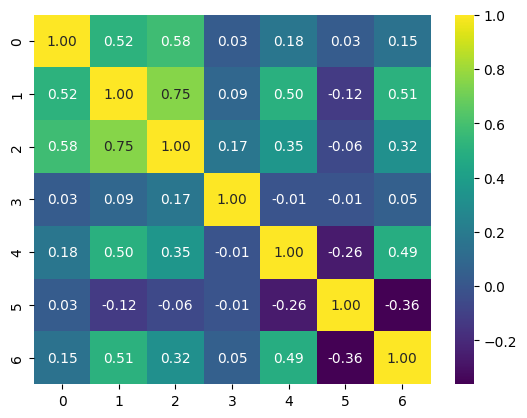

In [8]:
# Con la representación de vectores podemos calcular correlaciones
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt

pearson_matrix = Correlation.corr(vector_df, 'features').collect()[0][0]

sns.heatmap(pearson_matrix.toArray(), annot=True, fmt=".2f", cmap='viridis')

# Estandarización
Como recordamos de los módulos anteriores es deseable que los datos se encuentren estandarizados o normalizados, para evitar que la magnitud de ciertos atributos dominen el proceso de entrenamiento. El módulo `pyspark.ml.feature` tiene varias alternativas. A continuación se presenta una.

In [9]:
from pyspark.ml.feature import StandardScaler

standard_scaler = StandardScaler(inputCol='features', outputCol='scaled')
scale_model = standard_scaler.fit(vector_df)

scaled_df = scale_model.transform(vector_df)
scaled_df.show()

+--------------------+-------+--------------------+
|            features|  price|              scaled|
+--------------------+-------+--------------------+
|[3.0,1.0,1180.0,5...| 221900|[3.22559199779093...|
|[3.0,2.25,2570.0,...| 538000|[3.22559199779093...|
|[2.0,1.0,770.0,10...| 180000|[2.15039466519395...|
|[4.0,3.0,1960.0,5...| 604000|[4.30078933038790...|
|[3.0,2.0,1680.0,8...| 510000|[3.22559199779093...|
|[4.0,4.5,5420.0,1...|1225000|[4.30078933038790...|
|[3.0,2.25,1715.0,...| 257500|[3.22559199779093...|
|[3.0,1.5,1060.0,9...| 291850|[3.22559199779093...|
|[3.0,1.0,1780.0,7...| 229500|[3.22559199779093...|
|[3.0,2.5,1890.0,6...| 323000|[3.22559199779093...|
|[3.0,2.5,3560.0,9...| 662500|[3.22559199779093...|
|[2.0,1.0,1160.0,6...| 468000|[2.15039466519395...|
|[3.0,1.0,1430.0,1...| 310000|[3.22559199779093...|
|[3.0,1.75,1370.0,...| 400000|[3.22559199779093...|
|[5.0,2.0,1810.0,4...| 530000|[5.37598666298488...|
|[4.0,3.0,2950.0,5...| 650000|[4.30078933038790...|
|[3.0,2.0,18

# Regresión lineal
Como ejemplo de un tipo de modelo a entrenar usaremos una regresión lineal básica para tratar de predecir el precio. Para ellos utilizaremos los datos estandarizados.

In [10]:
# Nótese que no se hace partición de datos de entrenamiento (ejercicio posterior).
from pyspark.ml.regression import LinearRegression

regression = LinearRegression(featuresCol='scaled', labelCol='price')
regression_model = regression.fit(scaled_df)

print('Pesos: {}\n b: {}'.format(regression_model.coefficients, regression_model.intercept))

print('RMSE: {} r2: {}'.format(
    regression_model.summary.rootMeanSquaredError,
    regression_model.summary.r2))

scaled_df.describe().show()

# Si se quiere hacer predicciones nada más se requiere llamar a regression_model.transform(df)
# Esto regresa el dataset con una columna nueva

24/07/03 02:01:22 WARN Instrumentation: [d631c6c8] regParam is zero, which might cause numerical instability and overfitting.
24/07/03 02:01:22 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Pesos: [-64395.4731868764,50862.92091861813,278511.1119748758,-12339.081074521953,30946.977799688568,11683.836709724566,-94825.53343750733]
 b: 6223698.139208457
RMSE: 244323.5319029395 r2: 0.5570878698871073
+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|             21613|
|   mean|       540088.1418|
| stddev|367127.19648270035|
|    min|             75000|
|    max|           7700000|
+-------+------------------+



# Ejercicio
- Dividir los datos leídos desde la base de datos en dos conjuntos utilizando las funcionalidades de muestreo de Spark.
- Entrene el modelo en uno y evalúe en otro. Escriba los resultados evaluados en una tabla en Postgresql.
- Implementar un esquema de k-fold cross validation. Evalúe los resultados según RMSE y r2.
- Pruebe diferentes parámetros a la regresión.
- Pruebe diferentes tipos de regresión.

In [11]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

# Dataframe: scaled_df
train_df, test_df = scaled_df.randomSplit([0.8, 0.2], seed=12345)

print('Train dataset:')
train_df.show()
print('Test dataset:')
test_df.show()

Train dataset:
+--------------------+-------+--------------------+
|            features|  price|              scaled|
+--------------------+-------+--------------------+
|[0.0,0.0,290.0,20...| 142000|[0.0,0.0,0.315752...|
|[0.0,0.0,844.0,42...| 139950|[0.0,0.0,0.918948...|
|[0.0,0.0,1470.0,9...| 380000|[0.0,0.0,1.600538...|
|[0.0,0.0,1470.0,4...| 235000|[0.0,0.0,1.600538...|
|[0.0,0.0,2460.0,8...| 355000|[0.0,0.0,2.678452...|
|[0.0,0.0,3064.0,4...|1095000|[0.0,0.0,3.336088...|
|[0.0,0.75,384.0,2...| 265000|[0.0,0.9738196289...|
|[0.0,1.0,390.0,59...| 228000|[0.0,1.2984261719...|
|[0.0,1.5,1430.0,1...| 288000|[0.0,1.9476392579...|
|[0.0,2.5,1490.0,7...| 320000|[0.0,3.2460654298...|
|[0.0,2.5,1810.0,5...| 240000|[0.0,3.2460654298...|
|[0.0,2.5,2290.0,8...| 339950|[0.0,3.2460654298...|
|[1.0,0.0,600.0,24...| 280000|[1.07519733259697...|
|[1.0,0.0,670.0,43...|  75000|[1.07519733259697...|
|[1.0,0.0,690.0,23...| 484000|[1.07519733259697...|
|[1.0,0.5,880.0,16...| 255000|[1.07519733259697..

In [12]:
regression_2 = LinearRegression(featuresCol='scaled', labelCol='price', maxIter=10)

# We use a ParamGridBuilder to construct a grid of parameters to search over.
# TrainValidationSplit will try all combinations of values and determine best model using
# the evaluator.
paramGrid = ParamGridBuilder()\
    .addGrid(regression_2.regParam, [0.1, 0.01]) \
    .addGrid(regression_2.fitIntercept, [False, True])\
    .addGrid(regression_2.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

In [13]:
# In this case the estimator is simply the linear regression.
# A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
tvs = TrainValidationSplit(estimator=regression_2,
                           estimatorParamMaps=paramGrid,
                           evaluator=RegressionEvaluator(),
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

In [14]:
# Run TrainValidationSplit, and choose the best set of parameters.
regression_model_2 = regression_2.fit(train_df)

24/07/03 02:01:22 WARN Instrumentation: [9716472a] regParam is zero, which might cause numerical instability and overfitting.


In [15]:
# Make predictions on test data. model is the model with combination of parameters
# that performed best.
df_predicted = regression_model_2.transform(test_df).select('scaled', 'price', 'features', 'prediction')
df_predicted.show()


+--------------------+-------+--------------------+------------------+
|              scaled|  price|            features|        prediction|
+--------------------+-------+--------------------+------------------+
|[0.0,0.0,5.237136...|1295650|[0.0,0.0,4810.0,2...|1414914.5782275032|
|[1.07519733259697...| 310000|[1.0,0.75,520.0,2...|203148.81266585272|
|[1.07519733259697...| 262000|[1.0,0.75,520.0,1...|307446.63236617856|
|[1.07519733259697...| 200000|[1.0,0.75,680.0,9...|229848.39303534664|
|[1.07519733259697...| 124000|[1.0,0.75,840.0,7...|301676.59160624165|
|[1.07519733259697...| 192500|[1.0,1.0,470.0,63...| 282559.6463800566|
|[1.07519733259697...| 275000|[1.0,1.0,520.0,48...|254204.24542678334|
|[1.07519733259697...| 314200|[1.0,1.0,610.0,60...| 339811.8676569676|
|[1.07519733259697...| 415000|[1.0,1.0,700.0,25...| 231996.3713818211|
|[1.07519733259697...| 403500|[1.0,1.0,700.0,56...|280162.61327372957|
|[1.07519733259697...| 385195|[1.0,1.0,710.0,60...|  66647.5839935299|
|[1.07

In [16]:
df_predicted = df_predicted.withColumnRenamed('price','label')
rmse_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
r2_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

In [17]:
rmse_result = rmse_evaluator.evaluate(df_predicted)
print(f'Root Mean Squared Error = {rmse_result}')

Root Mean Squared Error = 232691.4778411597


In [18]:
r2_result = r2_evaluator.evaluate(df_predicted)
print(f'R2 = {r2_result}')

R2 = 0.568398351280582


In [19]:
# La cantidad de pisos y el precio fueron cargados como string. Deben ajustarse.
df_predicted_corrected = df_predicted \
    .withColumn('label', df_predicted['label'].cast(FloatType())) \
    .withColumn('prediction', df_predicted['prediction'].cast(FloatType()))


df_predicted_corrected.show()

+--------------------+---------+--------------------+----------+
|              scaled|    label|            features|prediction|
+--------------------+---------+--------------------+----------+
|[0.0,0.0,5.237136...|1295650.0|[0.0,0.0,4810.0,2...| 1414914.6|
|[1.07519733259697...| 310000.0|[1.0,0.75,520.0,2...| 203148.81|
|[1.07519733259697...| 262000.0|[1.0,0.75,520.0,1...| 307446.62|
|[1.07519733259697...| 200000.0|[1.0,0.75,680.0,9...| 229848.39|
|[1.07519733259697...| 124000.0|[1.0,0.75,840.0,7...|  301676.6|
|[1.07519733259697...| 192500.0|[1.0,1.0,470.0,63...| 282559.66|
|[1.07519733259697...| 275000.0|[1.0,1.0,520.0,48...| 254204.25|
|[1.07519733259697...| 314200.0|[1.0,1.0,610.0,60...| 339811.88|
|[1.07519733259697...| 415000.0|[1.0,1.0,700.0,25...| 231996.38|
|[1.07519733259697...| 403500.0|[1.0,1.0,700.0,56...| 280162.62|
|[1.07519733259697...| 385195.0|[1.0,1.0,710.0,60...| 66647.586|
|[1.07519733259697...| 395000.0|[1.0,1.0,730.0,30...|  379556.1|
|[1.07519733259697...| 25

In [20]:
from pyspark.sql.functions import col

df_predicted_selected = df_predicted_corrected.select(
            col('label'),
            col('prediction'))

df_predicted_selected.show()
df_predicted_selected.printSchema()

+---------+----------+
|    label|prediction|
+---------+----------+
|1295650.0| 1414914.6|
| 310000.0| 203148.81|
| 262000.0| 307446.62|
| 200000.0| 229848.39|
| 124000.0|  301676.6|
| 192500.0| 282559.66|
| 275000.0| 254204.25|
| 314200.0| 339811.88|
| 415000.0| 231996.38|
| 403500.0| 280162.62|
| 385195.0| 66647.586|
| 395000.0|  379556.1|
| 250000.0|  362787.1|
|  90000.0|  413776.7|
| 395000.0| 262369.62|
| 248000.0| 372763.28|
| 267000.0| 395104.03|
| 235000.0|  347217.5|
| 525000.0|  367904.1|
| 165000.0|  410696.7|
+---------+----------+
only showing top 20 rows

root
 |-- label: float (nullable = true)
 |-- prediction: float (nullable = false)



In [21]:
# Almacenar los resultados en una base de datos
df_predicted_selected \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "predicciones") \
    .save()

Siguiente: 
* Implementar un esquema de k-fold cross validation. Evalúe los resultados según RMSE y r2.
* Pruebe diferentes parámetros a la regresión.
* Pruebe diferentes tipos de regresión.

In [22]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

train_df_renamed = df_predicted.withColumnRenamed('price','label')
regression_3 = LinearRegression(featuresCol='scaled', labelCol='label', maxIter=10)

# We now treat the Pipeline as an Estimator, wrapping it in a CrossValidator instance.
# This will allow us to jointly choose parameters for all Pipeline stages.
# A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
# We use a ParamGridBuilder to construct a grid of parameters to search over.
# With 3 values for hashingTF.numFeatures and 2 values for lr.regParam,
# this grid will have 3 x 2 = 6 parameter settings for CrossValidator to choose from.
paramGrid = ParamGridBuilder()\
    .addGrid(regression_3.regParam, [0.1, 0.01]) \
    .addGrid(regression_3.fitIntercept, [False, True])\
    .addGrid(regression_3.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

crossval = CrossValidator(estimator=regression_3,
                          estimatorParamMaps=paramGrid,
                          evaluator=rmse_evaluator,
                          numFolds=10)  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train_df_renamed)

IllegalArgumentException: requirement failed: Column prediction already exists.